In [1]:
%pwd

'/home/gorkemkola/Desktop/Projects/EnsembleNet/research'

In [2]:
%cd ..
%pwd

/home/gorkemkola/Desktop/Projects/EnsembleNet


'/home/gorkemkola/Desktop/Projects/EnsembleNet'

In [ ]:
import os
from ensemblenet.entity import TrainingConfig
from ensemblenet.constants import *
from ensemblenet.utils import read_yaml, create_directories, logger

In [4]:
class ConfigurationManager:
    def __init__(
            self,
            config_filepath = CONFIG_FILE_PATH,
            params_filepath = PARAMS_FILE_PATH,
        ) -> None:

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

        # --- Model Selection and Validation ---
        # Add 'attention_ensemble' to your allowed list if that's the name you use
        allowed_models = [
            "resnet", 
            "inception_v3", 
            "vit", 
            "attention_ensemble", 
            "squeezenet", 
            "shufflenet", 
            "mobilenet", 
            "attention_ensemble_better",
            "mnasnet",
            "ensemblenet",
            "ensemblenet0",
            "ensemblenet1",
            "ensemblenet2"

        ]
        if self.params.MODEL_NAME not in allowed_models:
             raise ValueError(f"Invalid MODEL_NAME '{self.params.MODEL_NAME}' in params.yaml. Choose from {allowed_models}")
        self.model_name = self.params.MODEL_NAME
        # --- End ---

        create_directories(
            [
                self.config.artifacts_root,
                Path(self.config.training.root_dir),
                Path(self.config.training.tensorboard_log_dir),
            ]
        )

    def _validate_data_dirs(self, train_dir, val_dir, test_dir, expected_classes):
        """Check if data directories exist and validate class count."""
        paths_to_check = {"train": train_dir, "validation": val_dir, "test": test_dir}
        for split, path in paths_to_check.items():
            if not os.path.isdir(path):
                raise NotADirectoryError(f"{split.capitalize()} data directory not found at: {path}")
            try:
                # Count subdirectories (classes) in the training dir for validation
                if split == 'train':
                    actual_classes = len([name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))])
                    if actual_classes == 0:
                         raise ValueError(f"No subdirectories (classes) found in {path}")
                    if actual_classes != expected_classes:
                         logger.warning(f"Class count mismatch in {split} dir! params.yaml says {expected_classes}, "
                                       f"but found {actual_classes} subdirectories in {path}. Using {expected_classes} from params.")
                         # Decide if this should be a hard error:
                         # raise ValueError(f"Class count mismatch...")
                    else:
                         logger.info(f"Validated {actual_classes} classes in {path}, matching params.yaml.")
            except Exception as e:
                 logger.error(f"Could not validate directory structure in {path}: {e}")
                 raise

    def get_training_config(self) -> TrainingConfig:
        config_train = self.config.training
        config_data = self.config.data_ingestion
        config_ensemble = self.config.prepare_ensemble_model
        params = self.params

        # --- Get Data Paths ---
        train_data_path = Path(config_data.train_dir)
        valid_data_path = Path(config_data.val_dir)
        test_data_path = Path(config_data.test_dir)
        # --- End ---

        # --- Get Classes and Pretrained Flag ---
        num_classes = params.CLASSES
        # Determine if pretrained weights should be used based on param
        use_pretrained = params.PRETRAINED_WEIGHTS is not None and params.PRETRAINED_WEIGHTS.upper() != 'NONE'
        logger.info(f"Number of classes set to: {num_classes}")
        logger.info(f"Use pretrained weights: {use_pretrained} (Based on PRETRAINED_WEIGHTS: {params.PRETRAINED_WEIGHTS})")
        # --- End ---

        # --- Validate Data Directories ---
        self._validate_data_dirs(train_data_path, valid_data_path, test_data_path, num_classes)
        # --- End ---

        # --- Get Ensemble Model Path ---
        ensemble_model_path = Path(config_ensemble.ensemble_model_path)
        if self.model_name == "attention_ensemble" and not ensemble_model_path.exists():
             logger.warning(f"Selected MODEL_NAME is 'attention_ensemble', but the model file "
                            f"at {ensemble_model_path} does not exist!")

        # --- Construct model-specific save paths using templates ---
        last_model_path = Path(config_train.last_model_path_template.format(model_name=self.model_name))
        best_model_path = Path(config_train.best_model_path_template.format(model_name=self.model_name))
        create_directories([last_model_path.parent, best_model_path.parent]) # Ensure parent dirs exist
        # --- End ---

        # --- Log Image Size Warning (as before) ---
        expected_size = None
        if self.model_name == "inception_v3": expected_size = (299, 299)
        elif self.model_name == "vit": expected_size = (224, 224)
        current_size = tuple(params.IMAGE_SIZE[:2])
        if expected_size and current_size != expected_size:
            logger.warning(f"Model '{self.model_name}' typically expects input size {expected_size}, "
                           f"but IMAGE_SIZE is set to {current_size}.")
        # --- End Log ---

        find_lr_flag = getattr(params, 'FIND_LR', False) # Default to False if not in params
        logger.info(f"Run Learning Rate Finder: {find_lr_flag}")
        # --- Construct LR finder plot path ---
        lr_plot_filename = f"lr_finder_plot_{self.model_name}.png"
        lr_finder_plot_path = Path(config_train.root_dir) / lr_plot_filename
        create_directories([lr_finder_plot_path.parent]) # Ensure parent dir exists

        training_config = TrainingConfig(
            root_dir=Path(config_train.root_dir),
            last_model_path=last_model_path,
            best_model_path=best_model_path,
            train_data_path=train_data_path,
            valid_data_path=valid_data_path,
            test_data_path=test_data_path,
            attention_ensemble_model_path=ensemble_model_path,
            model_name=self.model_name,
            num_classes=num_classes,         
            use_pretrained=use_pretrained,   
            lr_finder_plot_path=lr_finder_plot_path,    
            params_epochs=params.EPOCHS,
            params_batch_size=params.BATCH_SIZE,
            params_augmentation=params.AUGMENTATION,
            params_image_size=params.IMAGE_SIZE,
            params_early_stopping_patience=params.EARLY_STOPPING_PATIENCE,
            params_learning_rate=params.LEARNING_RATE,
            params_random_state=params.RANDOM_STATE,
            params_find_lr=find_lr_flag,                    
        )
        
        return training_config

In [5]:
ConfigurationManager().get_training_config()

[2025-06-21 13:34:25,594: INFO: utils: yaml file config/config.yaml loaded successfully:]
[2025-06-21 13:34:25,597: INFO: utils: yaml file config/params.yaml loaded successfully:]
[2025-06-21 13:34:25,598: INFO: utils: created directory at: artifacts:]
[2025-06-21 13:34:25,599: INFO: utils: created directory at: artifacts/training:]
[2025-06-21 13:34:25,600: INFO: utils: created directory at: artifacts/training/logs:]
[2025-06-21 13:34:25,600: INFO: 2615980527: Number of classes set to: 257:]
[2025-06-21 13:34:25,600: INFO: 2615980527: Use pretrained weights: True (Based on PRETRAINED_WEIGHTS: IMAGENET1K_V1):]
[2025-06-21 13:34:25,601: ERROR: 2615980527: Could not validate directory structure in artifacts/data_ingestion/train: No subdirectories (classes) found in artifacts/data_ingestion/train:]


ValueError: No subdirectories (classes) found in artifacts/data_ingestion/train

In [ ]:
from ensemblenet.components.ensemblenet import EnsembleNet

In [ ]:
import traceback
import math
import numpy as np
import pandas as pd
import csv
from pathlib import Path
from datetime import datetime
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from ignite.engine import Engine
from ignite.handlers import FastaiLRFinder
import os

torch.manual_seed(24120200)

class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance.
    
    Focal Loss = -alpha * (1 - p_t)^gamma * log(p_t)
    
    Args:
        alpha (float or Tensor): Weighting factor (default: 1.0)
        gamma (float): Focusing parameter (default: 2.0)
        reduction (str): 'mean', 'sum', or 'none' (default: 'mean')
        ignore_index (int): Index to ignore (default: -100)
    """
    
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean', ignore_index=-100):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.ce_loss = nn.CrossEntropyLoss(reduction='none', ignore_index=ignore_index)
    
    def forward(self, outputs, targets):
        """
        Args:
            outputs (Tensor): Model predictions (logits) of shape (N, C)
            targets (Tensor): Ground truth labels of shape (N,)
        
        Returns:
            Tensor: Focal loss
        """
        ce_loss = self.ce_loss(outputs, targets)
        p_t = torch.exp(-ce_loss)  # Convert back to probabilities
        
        # Handle ignore_index
        if self.ignore_index >= 0:
            ignore_mask = targets == self.ignore_index
            p_t = p_t.masked_fill(ignore_mask, 1.0)
        
        # Calculate focal weight
        focal_weight = (1 - p_t) ** self.gamma
        
        # Apply alpha weighting
        if isinstance(self.alpha, (float, int)):
            alpha_weight = self.alpha
        else:
            alpha_weight = self.alpha.gather(0, targets)
        
        focal_loss = alpha_weight * focal_weight * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class Training:
    def __init__(self, config: TrainingConfig):
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        logger.info(f"Using device: {self.device}")
        self.model = None
        self.train_loader = None
        self.valid_loader = None
        self.test_loader = None
        
        # Initialize CSV logging
        self.setup_csv_logging()
        
    def setup_csv_logging(self):
        """Setup CSV files for logging metrics and hyperparameters"""
        # Create logging directory if it doesn't exist
        log_dir = Path(self.config.root_dir) / "logs"
        log_dir.mkdir(exist_ok=True)
        
        # Generate timestamp for unique file names
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        # Define CSV file paths
        self.metrics_csv_path = log_dir / f"training_metrics_{self.config.model_name}.csv"
        self.hyperparams_csv_path = log_dir / f"hyperparameters_{self.config.model_name}.csv"
        self.lr_finder_csv_path = log_dir / f"lr_finder_results_{self.config.model_name}.csv"
        
        # Initialize metrics CSV with headers
        metrics_headers = [
            'epoch', 'train_loss', 'valid_loss', 'accuracy', 'precision', 
            'recall', 'f1_score', 'learning_rate', 'is_best_model', 
            'early_stopping_counter', 'timestamp'
        ]
        
        with open(self.metrics_csv_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(metrics_headers)
        
        logger.info(f"Metrics CSV initialized: {self.metrics_csv_path}")
        
        # Save hyperparameters immediately
        self.save_hyperparameters()
        
    def save_hyperparameters(self):
        """Save all hyperparameters and configuration to CSV"""
        hyperparams_data = []
        
        # Get all config attributes
        config_dict = vars(self.config)
        
        # Add system information
        hyperparams_data.extend([
            ('timestamp', datetime.now().isoformat()),
            ('device', str(self.device)),
            ('torch_version', torch.__version__),
            ('cuda_available', torch.cuda.is_available()),
            ('cuda_version', torch.version.cuda if torch.cuda.is_available() else 'N/A'),
        ])
        
        # Add configuration parameters
        for key, value in config_dict.items():
            hyperparams_data.append((key, str(value)))
        
        # Add derived parameters
        if hasattr(self, 'train_loader') and self.train_loader:
            hyperparams_data.extend([
                ('total_train_samples', len(self.train_loader.dataset)),
                ('train_batches_per_epoch', len(self.train_loader)),
            ])
        
        if hasattr(self, 'valid_loader') and self.valid_loader:
            hyperparams_data.extend([
                ('total_valid_samples', len(self.valid_loader.dataset)),
                ('valid_batches_per_epoch', len(self.valid_loader)),
            ])
            
        if hasattr(self, 'test_loader') and self.test_loader:
            hyperparams_data.extend([
                ('total_test_samples', len(self.test_loader.dataset)),
                ('test_batches_per_epoch', len(self.test_loader)),
            ])
        
        # Save to CSV
        df_hyperparams = pd.DataFrame(hyperparams_data, columns=['parameter', 'value'])
        df_hyperparams.to_csv(self.hyperparams_csv_path, index=False)
        
        logger.info(f"Hyperparameters saved to: {self.hyperparams_csv_path}")
        
    def log_metrics_to_csv(self, epoch, train_loss, valid_loss, accuracy, precision, 
                          recall, f1, learning_rate, is_best_model, early_stopping_counter):
        """Log training metrics to CSV"""
        timestamp = datetime.now().isoformat()
        
        metrics_row = [
            epoch + 1,  # 1-indexed for readability
            train_loss,
            valid_loss,
            accuracy,
            precision,
            recall,
            f1,
            learning_rate,
            is_best_model,
            early_stopping_counter,
            timestamp
        ]
        
        with open(self.metrics_csv_path, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(metrics_row)
            
    def save_lr_finder_results(self, lr_finder, suggested_lr=None):
        """Save LR finder results to CSV, including suggested learning rate"""
        try:
            results = lr_finder.get_results()
            if results and 'lr' in results and 'loss' in results:
                df_lr = pd.DataFrame({
                    'learning_rate': results['lr'],
                    'loss': results['loss']
                })
                df_lr.to_csv(self.lr_finder_csv_path, index=False)
                logger.info(f"LR Finder results saved to: {self.lr_finder_csv_path}")
                
                # Save suggested learning rate to a separate file
                if suggested_lr is not None:
                    # Handle both Path objects and strings
                    if hasattr(self.lr_finder_csv_path, 'parent'):
                        # Path object
                        lr_suggestion_path = self.lr_finder_csv_path.parent / (self.lr_finder_csv_path.stem + '_suggested_lr.txt')
                    else:
                        # String path
                        lr_suggestion_path = str(self.lr_finder_csv_path).replace('.csv', '_suggested_lr.txt')
                    
                    with open(lr_suggestion_path, 'w') as f:
                        f.write(str(suggested_lr))
                    logger.info(f"Suggested learning rate ({suggested_lr:.2e}) saved to: {lr_suggestion_path}")
            else:
                logger.warning("No LR Finder results to save")
        except Exception as e:
            logger.error(f"Error saving LR Finder results: {e}")

    def load_suggested_lr(self):
        """Load previously saved suggested learning rate"""
        try:
            # Handle both Path objects and strings
            if hasattr(self.lr_finder_csv_path, 'parent'):
                # Path object
                lr_suggestion_path = self.lr_finder_csv_path.parent / (self.lr_finder_csv_path.stem + '_suggested_lr.txt')
            else:
                # String path
                lr_suggestion_path = str(self.lr_finder_csv_path).replace('.csv', '_suggested_lr.txt')
            
            if os.path.exists(lr_suggestion_path):
                with open(lr_suggestion_path, 'r') as f:
                    suggested_lr = float(f.read().strip())
                logger.info(f"Loaded previously suggested learning rate: {suggested_lr:.2e}")
                return suggested_lr
            else:
                logger.info("No previously saved suggested learning rate found")
                return None
        except Exception as e:
            logger.error(f"Error loading suggested learning rate: {e}")
            return None

    def find_optimal_lr_ignite(self, start_lr, end_lr=10, num_iter=100, step_mode="exp", force_recalculate=False):
        """
        Runs the LR Range Test using ignite.handlers.FastaiLRFinder.
        Returns a suggested learning rate and saves results to CSV.
        
        Args:
            end_lr: Maximum learning rate to test
            num_iter: Number of iterations
            step_mode: Step mode for learning rate schedule
            force_recalculate: If True, recalculates even if saved results exist
        """
        if not self.model or not self.train_loader:
            logger.error("Model and Train Loader must be initialized before running LR Finder.")
            return None

        # Check if we have a previously saved suggested learning rate
        if not force_recalculate:
            saved_lr = self.load_suggested_lr()
            if saved_lr is not None:
                logger.info(f"Using previously calculated suggested learning rate: {saved_lr:.2e}")
                logger.info("Set force_recalculate=True to recalculate from scratch")
                return saved_lr

        logger.info(f"--- Running Learning Rate Finder (Ignite) ---")
        logger.info(f"Using end_lr={end_lr}, num_iter={num_iter}, step_mode='{step_mode}'")

        self.model.train()
        criterion = nn.CrossEntropyLoss()
        temp_optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=1e-7)

        def update_fn(engine, batch):
            inputs, labels = batch
            inputs, labels = inputs.to(self.device), labels.to(self.device)

            temp_optimizer.zero_grad()
            outputs = self.model(inputs)
            if self.config.model_name == "attention_ensemble":
                logits = outputs
                loss = F.cross_entropy(logits, labels)
            elif isinstance(outputs, tuple) and hasattr(outputs, 'logits') and hasattr(outputs, 'aux_logits') and self.config.model_name == "inception_v3":
                loss = criterion(outputs.logits, labels)
            elif isinstance(outputs, tuple):
                loss = criterion(outputs[0], labels)
            else:
                loss = criterion(outputs, labels)

            loss.backward()
            temp_optimizer.step()
            return loss.item()

        finder_engine = Engine(update_fn)
        lr_finder = FastaiLRFinder()
        to_save = {"model": self.model, "optimizer": temp_optimizer}

        suggested_lr_final = None
        try:
            with lr_finder.attach(finder_engine, to_save=to_save, start_lr=start_lr, end_lr=end_lr) as trainer_with_lr_finder:
                trainer_with_lr_finder.run(self.train_loader, max_epochs=1)

            suggested_lr = lr_finder.lr_suggestion()

            logger.info("Plotting LR Finder results...")
            fig = lr_finder.plot()
            if fig:
                plot_path = self.config.lr_finder_plot_path
                logger.info(f"LR Finder plot saved to: {plot_path}")
            else:
                logger.warning("Could not generate LR Finder plot.")

            if suggested_lr is None:
                logger.warning("Ignite LR Finder could not suggest a learning rate. Using fallback calculation.")
                results = lr_finder.get_results()
                if results and 'lr' in results and 'loss' in results and len(results['loss']) > 0:
                    min_loss_idx = results['loss'].index(min(results['loss']))
                    min_loss_lr = results['lr'][min_loss_idx]
                    suggested_lr_final = min_loss_lr / 10.0
                    logger.info(f"LR at Minimum Loss: {min_loss_lr:.2e}")
                    logger.info(f"Fallback suggestion (Min Loss / 10): {suggested_lr_final:.2e}")
                else:
                    logger.warning("Could not retrieve results for fallback calculation.")
                    suggested_lr_final = None
            else:
                logger.info(f"Ignite LR Finder suggested learning rate: {suggested_lr:.2e}")
                suggested_lr_final = suggested_lr

            # Apply bounds checking
            if suggested_lr_final is not None:
                if suggested_lr_final > 0.1:
                    logger.warning(f"Suggested LR {suggested_lr_final:.2e} seems high. Clamping to 0.1. Please check the plot!")
                    suggested_lr_final = 0.1
                elif suggested_lr_final < 1e-7:
                    logger.warning(f"Suggested LR {suggested_lr_final:.2e} seems too low. Clamping to 1e-7. Please check the plot!")
                    suggested_lr_final = 1e-7

            # Save results including the suggested learning rate
            self.save_lr_finder_results(lr_finder, suggested_lr_final)

        except Exception as e:
            logger.error(f"Error during Ignite LR Finder execution: {e}")
            import traceback
            traceback.print_exc()
            suggested_lr_final = None

        logger.info("--- Learning Rate Finder (Ignite) Finished ---")
        return suggested_lr_final
    
    def build_model(self):
        """Builds/loads the specified model, using config flags."""
        logger.info(f"Building model: {self.config.model_name}")
        num_classes = self.config.num_classes
        use_pretrained = self.config.use_pretrained

        if self.config.model_name == "resnet":
            weights = models.ResNet50_Weights.IMAGENET1K_V1 if use_pretrained else None
            model = models.resnet50(weights=weights)
            log_msg = f"Loading ResNet50 with {'ImageNet pretrained' if use_pretrained else 'random'} weights."
            logger.info(log_msg)
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, num_classes)
            logger.info(f"Adapted ResNet FC layer for {num_classes} classes.")

        elif self.config.model_name == "inception_v3":
            weights = models.Inception_V3_Weights.IMAGENET1K_V1 if use_pretrained else None
            model = models.inception_v3(weights=weights, aux_logits=True, transform_input=True)
            log_msg = f"Loading Inception V3 with {'ImageNet pretrained' if use_pretrained else 'random'} weights."
            logger.info(log_msg)
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, num_classes)
            logger.info(f"Adapted Inception V3 main FC layer for {num_classes} classes.")
            if hasattr(model, 'AuxLogits') and model.AuxLogits is not None:
                num_ftrs_aux = model.AuxLogits.fc.in_features
                model.AuxLogits.fc = nn.Linear(num_ftrs_aux, num_classes)
                logger.info(f"Adapted Inception V3 auxiliary FC layer for {num_classes} classes.")
            else:
                logger.info("Inception V3 AuxLogits not present or adapted.")

        elif self.config.model_name == "vit":
            weights = models.ViT_B_16_Weights.IMAGENET1K_V1 if use_pretrained else None
            model = models.vit_b_16(weights=weights)
            log_msg = f"Loading ViT-B/16 with {'ImageNet pretrained' if use_pretrained else 'random'} weights."
            logger.info(log_msg)
            num_ftrs = model.heads.head.in_features
            model.heads.head = nn.Linear(num_ftrs, num_classes)
            logger.info(f"Adapted ViT classification head for {num_classes} classes.")

        elif self.config.model_name == "attention_ensemble":
            model_path = self.config.attention_ensemble_model_path
            logger.info(f"Loading Attention Ensemble model AND weights from: {model_path}")
            if not model_path.exists():
                raise FileNotFoundError(f"Attention ensemble model file not found at: {model_path}")
            try:
                model = torch.load(
                    model_path,
                    map_location=torch.device('cpu'),
                    weights_only=False
                )
                logger.info(f"Successfully loaded model structure and weights from {model_path}")
                final_layer_name = 'fc'
                if hasattr(model, final_layer_name):
                    final_layer = getattr(model, final_layer_name)
                    if isinstance(final_layer, nn.Linear):
                        num_ftrs = final_layer.in_features
                        if final_layer.out_features != num_classes:
                            logger.warning(f"Adapting final layer '{final_layer_name}' of loaded attention model. Output: {final_layer.out_features} -> {num_classes}")
                            setattr(model, final_layer_name, nn.Linear(num_ftrs, num_classes))
                        else:
                            logger.info(f"Final layer '{final_layer_name}' already matches class count ({num_classes}).")
                    else:
                        logger.warning(f"Attribute '{final_layer_name}' is not nn.Linear. Manual adaptation might be needed.")
                else:
                    logger.warning(f"Could not find final layer '{final_layer_name}'. Assuming loaded model output is correct.")
            except Exception as e:
                logger.error(f"Failed to load or adapt attention ensemble model from {model_path}: {e}")
                raise
        elif self.config.model_name == "ensemblenet":
            model = EnsembleNet(num_classes, embed_dim=768)

        elif self.config.model_name == "ensemblenet0":
            model = EnsembleNet(num_classes, embed_dim=768)
            weights = [
                "artifacts/training/model_mobilenet_best.pth",
                "artifacts/training/model_mnasnet_best.pth",
                "artifacts/training/model_squeezenet_best.pth"
            ]
                        
            model.load_backbone_weights(weights, strict=False)
            model.freeze_backbones()
        elif self.config.model_name == "ensemblenet1":
            model = torch.load(
                "artifacts/training/model_ensemblenet0_best.pth",
                map_location=torch.device('cpu'),
                weights_only=False
            )
            model.unfreeze_backbones()
            
        elif self.config.model_name == "ensemblenet2":
            model = EnsembleNet(num_classes, embed_dim=768)
            weights = [
                "artifacts/training/model_mobilenet_best.pth",
                "artifacts/training/model_mnasnet_best.pth",
                "artifacts/training/model_squeezenet_best.pth"
            ]
                        
            model.load_backbone_weights(weights, strict=False)
            model.unfreeze_backbones()

        elif self.config.model_name == "squeezenet":
            model = models.squeezenet1_1(weights=models.SqueezeNet1_1_Weights)
            log_msg = f"Loading ViT-B/16 with {'ImageNet pretrained' if use_pretrained else 'random'} weights."
            logger.info(log_msg)
            model.classifier = nn.Sequential(
                nn.Dropout(p=0.5, inplace=True),
                nn.Conv2d(512, num_classes, kernel_size=(1, 1)),
                nn.ReLU(inplace=True),
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            )
        elif self.config.model_name == "shufflenet":
            model = models.shufflenet_v2_x0_5(weights=models.ShuffleNet_V2_X0_5_Weights)
            in_features = model._stage_out_channels[-1]
            model.fc = nn.Linear(in_features, num_classes)
            
        elif self.config.model_name == "mobilenet":
            model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights)
            lastconv_output_channels = 576
            last_channel = 1024
            dropout = 0.2
            model.classifier = nn.Sequential(
                nn.Linear(lastconv_output_channels, last_channel),
                nn.Hardswish(inplace=True),
                nn.Dropout(p=dropout, inplace=True),
                nn.Linear(last_channel, num_classes),
            )
        elif self.config.model_name == "attention_ensemble_better":
            pass
        elif self.config.model_name == "mnasnet":
            model = models.mnasnet0_5(weights=models.MNASNet0_5_Weights)
            dropout = 0.2
            model.classifier = nn.Sequential(nn.Dropout(p=dropout, inplace=True), nn.Linear(1280, num_classes))
        else:
            raise ValueError(f"Unsupported model name: {self.config.model_name}")

        self.model = model.to(self.device)
        logger.info(f"Model '{self.config.model_name}' built/loaded and moved to {self.device}.")
        
        # Update hyperparameters CSV with model info after building
        self.save_hyperparameters()

    def compute_dataset_mean_std(self, data_dir, image_size=(224, 224), batch_size=64, sample_limit=None):
        """
        Computes mean and std for all images in a directory (ImageFolder structure).
        Uses cached .npy arrays if available, otherwise computes and saves them.
        """
        mean_path = Path(data_dir) / "mean.npy"
        std_path = Path(data_dir) / "std.npy"

        if mean_path.exists() and std_path.exists():
            logger.info(f"Loading cached mean/std from {mean_path} and {std_path}")
            mean = np.load(mean_path)
            std = np.load(std_path)
            return mean.tolist(), std.tolist()

        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor()
        ])
        dataset = datasets.ImageFolder(data_dir, transform=transform)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)

        n_images = 0
        mean = 0.
        std = 0.
        for i, (imgs, _) in enumerate(loader):
            if sample_limit and n_images >= sample_limit:
                break
            imgs = imgs.view(imgs.size(0), imgs.size(1), -1)
            mean += imgs.mean(2).sum(0)
            std += imgs.std(2).sum(0)
            n_images += imgs.size(0)
            if sample_limit and n_images >= sample_limit:
                break

        mean /= n_images
        std /= n_images

        np.save(mean_path, mean.cpu().numpy() if hasattr(mean, "cpu") else mean)
        np.save(std_path, std.cpu().numpy() if hasattr(std, "cpu") else std)
        logger.info(f"Saved computed mean/std to {mean_path} and {std_path}")

        return mean.tolist(), std.tolist()

    def prepare_data_loaders(self):
        """Prepares DataLoaders using pre-split train, validation, and test directories."""
        img_height, img_width, _ = self.config.params_image_size
        target_size = (img_height, img_width)
        mean, std = self.compute_dataset_mean_std(self.config.train_data_path)

        basic_transform = transforms.Compose([
            transforms.Resize(target_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

        if self.config.params_augmentation:
            train_transform = transforms.Compose([
                transforms.Resize(target_size),
                transforms.RandomRotation(30),
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean, std=std)
            ])
            logger.info("Using data augmentation for training.")
        else:
            train_transform = basic_transform
            logger.info("Not using data augmentation for training.")

        logger.info(f"Loading training data from: {self.config.train_data_path}")
        train_dataset = datasets.ImageFolder(
            root=self.config.train_data_path,
            transform=train_transform
        )

        logger.info(f"Loading validation data from: {self.config.valid_data_path}")
        valid_dataset = datasets.ImageFolder(
            root=self.config.valid_data_path,
            transform=basic_transform
        )

        logger.info(f"Loading test data from: {self.config.test_data_path}")
        test_dataset = datasets.ImageFolder(
            root=self.config.test_data_path,
            transform=basic_transform
        )

        if not (train_dataset.classes == valid_dataset.classes == test_dataset.classes):
            logger.warning("Class inconsistency detected between train/validation/test splits!")
        logger.info(f"Found {len(train_dataset.classes)} classes.")
        if len(train_dataset.classes) != self.config.num_classes:
            logger.warning(f"Number of classes found in data ({len(train_dataset.classes)}) "
                          f"does not match params.yaml ({self.config.num_classes}). Check data paths and params.")

        num_workers = min(os.cpu_count() // 2, 8) if os.cpu_count() else 4
        logger.info(f"Using {num_workers} workers for DataLoaders.")

        self.train_loader = DataLoader(
            dataset=train_dataset,
            batch_size=self.config.params_batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=True
        )
        self.valid_loader = DataLoader(
            dataset=valid_dataset,
            batch_size=self.config.params_batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True
        )
        self.test_loader = DataLoader(
            dataset=test_dataset,
            batch_size=self.config.params_batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True
        )

        logger.info(f"DataLoaders prepared:")
        logger.info(f"  Training samples: {len(train_dataset)}, Batches: {len(self.train_loader)}")
        logger.info(f"  Validation samples: {len(valid_dataset)}, Batches: {len(self.valid_loader)}")
        logger.info(f"  Test samples: {len(test_dataset)}, Batches: {len(self.test_loader)}")
        
        # Update hyperparameters with dataset info
        self.save_hyperparameters()

    @staticmethod
    def save_model(path: Path, model: nn.Module):
        logger.info(f"Saving model to: {path}")
        torch.save(model, path)

    def train(self):
        """Enhanced training method with comprehensive CSV logging and Cosine Annealing LR"""
        if not self.model or not self.train_loader or not self.valid_loader:
            logger.error("Model or DataLoaders not initialized. Call build_model() and prepare_data_loaders() first.")
            return

        logger.info(f"Starting training for model: {self.config.model_name}...")
        logger.info(f"Metrics will be logged to: {self.metrics_csv_path}")
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, self.model.parameters()), lr=self.config.params_learning_rate)
        
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=1-1/math.e,patience=self.config.params_early_stopping_patience // 4)
        
        logger.info(f"Using OneCycleLR scheduler with T_max={self.config.params_epochs}, eta_min=1e-6")

        best_valid_loss = float('inf')
        early_stopping_counter = 0

        for epoch in range(self.config.params_epochs):
            # Training Phase
            self.model.train()
            train_loss = 0.0
            train_pbar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{self.config.params_epochs} [Train]', leave=False)
            for inputs, labels in train_pbar:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(inputs)
                if self.config.model_name == "attention_ensemble":
                    logits = outputs
                    loss = F.cross_entropy(logits, labels)
                    display_loss = loss.item()
                elif isinstance(outputs, models.inception.InceptionOutputs) and self.model.training:
                    loss_main = criterion(outputs.logits, labels)
                    loss_aux = criterion(outputs.aux_logits, labels)
                    loss = loss_main + 0.4 * loss_aux
                    display_loss = loss.item()
                else:
                    outputs_logits = outputs[0] if isinstance(outputs, tuple) else outputs
                    loss = criterion(outputs_logits, labels)
                    display_loss = loss.item()
                loss.backward()
                optimizer.step()

                train_loss += display_loss * inputs.size(0)
                train_pbar.set_postfix({'loss': f'{display_loss:.4f}', 'lr': f"{optimizer.param_groups[0]['lr']:.1e}"})
            avg_train_loss = train_loss / len(self.train_loader.dataset)

            # Validation Phase
            self.model.eval()
            valid_loss = 0.0
            all_labels = []
            all_predictions = []
            valid_pbar = tqdm(self.valid_loader, desc=f'Epoch {epoch+1}/{self.config.params_epochs} [Valid]', leave=False)
            with torch.no_grad():
                for inputs, labels in valid_pbar:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = self.model(inputs)
                    outputs_logits = outputs[0] if isinstance(outputs, tuple) else outputs
                    loss = criterion(outputs_logits, labels)
                    valid_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs_logits.data, 1)
                    all_labels.extend(labels.cpu().numpy())
                    all_predictions.extend(predicted.cpu().numpy())
                    valid_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            avg_valid_loss = valid_loss / len(self.valid_loader.dataset)
            scheduler.step(avg_valid_loss)
            # Calculate metrics
            accuracy = accuracy_score(all_labels, all_predictions) * 100
            precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
            recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
            f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
            current_lr = optimizer.param_groups[0]['lr']

            logger.info(f'Epoch {epoch+1} Summary -> Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}, '
                       f'Valid Acc: {accuracy:.2f}%, Prec: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, LR: {current_lr:.2e}')

            # Determine if this is the best model
            is_best = avg_valid_loss < best_valid_loss
            
            # Log metrics to CSV
            self.log_metrics_to_csv(
                epoch=epoch,
                train_loss=avg_train_loss,
                valid_loss=avg_valid_loss,
                accuracy=accuracy,
                precision=precision,
                recall=recall,
                f1=f1,
                learning_rate=current_lr,
                is_best_model=is_best,
                early_stopping_counter=early_stopping_counter
            )
            
            # Save models
            self.save_model(path=self.config.last_model_path, model=self.model)
            
            if is_best:
                best_valid_loss = avg_valid_loss
                early_stopping_counter = 0
                self.save_model(path=self.config.best_model_path, model=self.model)
                logger.info(f'>>> Best model saved (Epoch {epoch+1}) with Valid Loss: {avg_valid_loss:.4f}')
            else:
                early_stopping_counter += 1
                logger.info(f'Validation loss did not improve. Counter: {early_stopping_counter}/{self.config.params_early_stopping_patience}')
                if early_stopping_counter >= self.config.params_early_stopping_patience:
                    logger.warning('--- Early stopping triggered ---')
                    break

        logger.info(f'Training finished for {self.config.model_name}.')
        logger.info(f'Best validation loss achieved: {best_valid_loss:.4f}')
        logger.info(f'Best model saved at: {self.config.best_model_path}')
        logger.info(f'Last model saved at: {self.config.last_model_path}')
        logger.info(f'Training metrics saved to: {self.metrics_csv_path}')
        logger.info(f'Hyperparameters saved to: {self.hyperparams_csv_path}')
        
        # Create a final summary CSV
        self.create_training_summary()
        
    def create_training_summary(self):
        """Create a summary CSV with final training results"""
        try:
            # Read the metrics CSV to get final results
            df_metrics = pd.read_csv(self.metrics_csv_path)
            if not df_metrics.empty:
                best_epoch_row = df_metrics.loc[df_metrics['is_best_model'] == True]
                final_epoch_row = df_metrics.iloc[-1]
                
                summary_data = {
                    'model_name': [self.config.model_name],
                    'total_epochs': [len(df_metrics)],
                    'best_epoch': [best_epoch_row['epoch'].iloc[0] if not best_epoch_row.empty else 'N/A'],
                    'best_valid_loss': [best_epoch_row['valid_loss'].iloc[0] if not best_epoch_row.empty else 'N/A'],
                    'best_accuracy': [best_epoch_row['accuracy'].iloc[0] if not best_epoch_row.empty else 'N/A'],
                    'final_train_loss': [final_epoch_row['train_loss']],
                    'final_valid_loss': [final_epoch_row['valid_loss']],
                    'final_accuracy': [final_epoch_row['accuracy']],
                    'final_f1_score': [final_epoch_row['f1_score']],
                    'early_stopped': [final_epoch_row['early_stopping_counter'] >= self.config.params_early_stopping_patience],
                    'training_completed': [datetime.now().isoformat()]
                }
                
                summary_df = pd.DataFrame(summary_data)
                summary_path = Path(self.config.root_dir) / "logs" / f"training_summary_{self.config.model_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
                summary_df.to_csv(summary_path, index=False)
                
                logger.info(f"Training summary saved to: {summary_path}")
        except Exception as e:
            logger.error(f"Error creating training summary: {e}")

[2025-06-21 00:23:24,739: INFO: utils: yaml file config/config.yaml loaded successfully:]
[2025-06-21 00:23:24,746: INFO: utils: yaml file config/params.yaml loaded successfully:]
[2025-06-21 00:23:24,747: INFO: utils: created directory at: artifacts:]
[2025-06-21 00:23:24,748: INFO: utils: created directory at: artifacts/training:]
[2025-06-21 00:23:24,748: INFO: utils: created directory at: artifacts/training/logs:]
[2025-06-21 00:23:24,748: INFO: 2355115549: Number of classes set to: 257:]
[2025-06-21 00:23:24,749: INFO: 2355115549: Use pretrained weights: True (Based on PRETRAINED_WEIGHTS: IMAGENET1K_V1):]
[2025-06-21 00:23:24,751: INFO: 2355115549: Validated 257 classes in artifacts/data_ingestion/train, matching params.yaml.:]
[2025-06-21 00:23:24,752: INFO: utils: created directory at: artifacts/training:]
[2025-06-21 00:23:24,752: INFO: utils: created directory at: artifacts/training:]
[2025-06-21 00:23:24,753: INFO: 2355115549: Run Learning Rate Finder: True:]
[2025-06-21 00:2

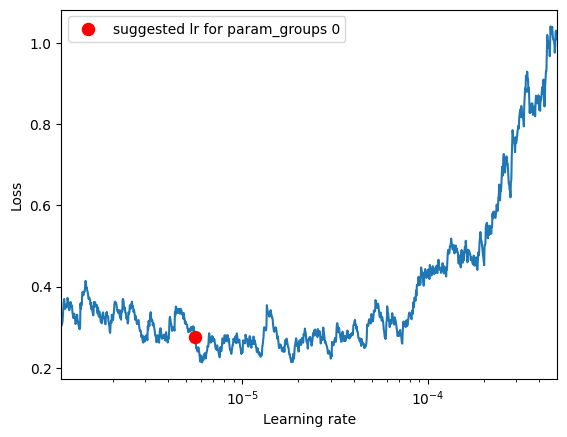

[2025-06-21 00:26:17,690: INFO: 470616600: LR Finder plot saved to: artifacts/training/lr_finder_plot_ensemblenet1.png:]
[2025-06-21 00:26:17,690: INFO: 470616600: Ignite LR Finder suggested learning rate: 5.54e-06:]
[2025-06-21 00:26:17,698: INFO: 470616600: LR Finder results saved to: artifacts/training/logs/lr_finder_results_ensemblenet1.csv:]
[2025-06-21 00:26:17,704: INFO: 470616600: Suggested learning rate (5.54e-06) saved to: artifacts/training/logs/lr_finder_results_ensemblenet1_suggested_lr.txt:]
[2025-06-21 00:26:17,706: INFO: 470616600: --- Learning Rate Finder (Ignite) Finished ---:]
[2025-06-21 00:26:17,707: INFO: 245092438: Overriding LR from params. Using Ignite LR Finder result: 5.54e-06:]
[2025-06-21 00:26:17,707: INFO: 470616600: Starting training for model: ensemblenet1...:]
[2025-06-21 00:26:17,708: INFO: 470616600: Metrics will be logged to: artifacts/training/logs/training_metrics_ensemblenet1.csv:]
[2025-06-21 00:26:17,711: INFO: 470616600: Using OneCycleLR sched

[2025-06-21 00:29:38,765: INFO: 470616600: Epoch 1 Summary -> Train Loss: 0.2802, Valid Loss: 1.0010, Valid Acc: 76.75%, Prec: 0.7901, Recall: 0.7675, F1: 0.7675, LR: 5.54e-06:]
[2025-06-21 00:29:38,766: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]


[2025-06-21 00:29:38,935: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_best.pth:]
[2025-06-21 00:29:39,072: INFO: 470616600: >>> Best model saved (Epoch 1) with Valid Loss: 1.0010:]


[2025-06-21 00:32:59,936: INFO: 470616600: Epoch 2 Summary -> Train Loss: 0.2457, Valid Loss: 0.9940, Valid Acc: 77.15%, Prec: 0.7913, Recall: 0.7715, F1: 0.7714, LR: 5.54e-06:]
[2025-06-21 00:32:59,938: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]
[2025-06-21 00:33:00,117: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_best.pth:]
[2025-06-21 00:33:00,279: INFO: 470616600: >>> Best model saved (Epoch 2) with Valid Loss: 0.9940:]


[2025-06-21 00:36:21,147: INFO: 470616600: Epoch 3 Summary -> Train Loss: 0.2247, Valid Loss: 0.9919, Valid Acc: 77.54%, Prec: 0.7921, Recall: 0.7754, F1: 0.7748, LR: 5.54e-06:]
[2025-06-21 00:36:21,151: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]


[2025-06-21 00:36:21,335: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_best.pth:]
[2025-06-21 00:36:21,493: INFO: 470616600: >>> Best model saved (Epoch 3) with Valid Loss: 0.9919:]


[2025-06-21 00:39:41,011: INFO: 470616600: Epoch 4 Summary -> Train Loss: 0.2124, Valid Loss: 0.9778, Valid Acc: 77.67%, Prec: 0.7922, Recall: 0.7767, F1: 0.7760, LR: 5.54e-06:]
[2025-06-21 00:39:41,012: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]
[2025-06-21 00:39:41,149: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_best.pth:]
[2025-06-21 00:39:41,286: INFO: 470616600: >>> Best model saved (Epoch 4) with Valid Loss: 0.9778:]


[2025-06-21 00:42:57,806: INFO: 470616600: Epoch 5 Summary -> Train Loss: 0.2015, Valid Loss: 0.9813, Valid Acc: 77.73%, Prec: 0.7935, Recall: 0.7773, F1: 0.7767, LR: 5.54e-06:]
[2025-06-21 00:42:57,807: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]
[2025-06-21 00:42:57,946: INFO: 470616600: Validation loss did not improve. Counter: 1/11:]


[2025-06-21 00:46:18,028: INFO: 470616600: Epoch 6 Summary -> Train Loss: 0.1872, Valid Loss: 0.9820, Valid Acc: 77.48%, Prec: 0.7901, Recall: 0.7748, F1: 0.7745, LR: 5.54e-06:]
[2025-06-21 00:46:18,029: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]


[2025-06-21 00:46:18,216: INFO: 470616600: Validation loss did not improve. Counter: 2/11:]


[2025-06-21 00:49:38,924: INFO: 470616600: Epoch 7 Summary -> Train Loss: 0.1761, Valid Loss: 0.9793, Valid Acc: 78.00%, Prec: 0.7962, Recall: 0.7800, F1: 0.7801, LR: 3.50e-06:]
[2025-06-21 00:49:38,925: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]


[2025-06-21 00:49:39,084: INFO: 470616600: Validation loss did not improve. Counter: 3/11:]


[2025-06-21 00:52:59,590: INFO: 470616600: Epoch 8 Summary -> Train Loss: 0.1736, Valid Loss: 0.9724, Valid Acc: 77.60%, Prec: 0.7907, Recall: 0.7760, F1: 0.7758, LR: 3.50e-06:]
[2025-06-21 00:52:59,592: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]
[2025-06-21 00:52:59,782: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_best.pth:]
[2025-06-21 00:52:59,920: INFO: 470616600: >>> Best model saved (Epoch 8) with Valid Loss: 0.9724:]


[2025-06-21 00:56:19,425: INFO: 470616600: Epoch 9 Summary -> Train Loss: 0.1687, Valid Loss: 0.9626, Valid Acc: 77.97%, Prec: 0.7954, Recall: 0.7797, F1: 0.7795, LR: 3.50e-06:]
[2025-06-21 00:56:19,426: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]


[2025-06-21 00:56:19,608: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_best.pth:]
[2025-06-21 00:56:19,745: INFO: 470616600: >>> Best model saved (Epoch 9) with Valid Loss: 0.9626:]


[2025-06-21 00:59:40,088: INFO: 470616600: Epoch 10 Summary -> Train Loss: 0.1675, Valid Loss: 0.9736, Valid Acc: 78.00%, Prec: 0.7958, Recall: 0.7800, F1: 0.7799, LR: 3.50e-06:]
[2025-06-21 00:59:40,089: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]


[2025-06-21 00:59:40,248: INFO: 470616600: Validation loss did not improve. Counter: 1/11:]


[2025-06-21 01:02:59,734: INFO: 470616600: Epoch 11 Summary -> Train Loss: 0.1663, Valid Loss: 0.9707, Valid Acc: 78.06%, Prec: 0.7947, Recall: 0.7806, F1: 0.7801, LR: 3.50e-06:]
[2025-06-21 01:02:59,735: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]


[2025-06-21 01:02:59,898: INFO: 470616600: Validation loss did not improve. Counter: 2/11:]


[2025-06-21 01:06:19,597: INFO: 470616600: Epoch 12 Summary -> Train Loss: 0.1655, Valid Loss: 0.9686, Valid Acc: 77.97%, Prec: 0.7946, Recall: 0.7797, F1: 0.7792, LR: 2.21e-06:]
[2025-06-21 01:06:19,598: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]


[2025-06-21 01:06:19,768: INFO: 470616600: Validation loss did not improve. Counter: 3/11:]


[2025-06-21 01:09:39,191: INFO: 470616600: Epoch 13 Summary -> Train Loss: 0.1550, Valid Loss: 0.9657, Valid Acc: 78.25%, Prec: 0.7972, Recall: 0.7825, F1: 0.7820, LR: 2.21e-06:]
[2025-06-21 01:09:39,193: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]


[2025-06-21 01:09:39,362: INFO: 470616600: Validation loss did not improve. Counter: 4/11:]


[2025-06-21 01:12:59,321: INFO: 470616600: Epoch 14 Summary -> Train Loss: 0.1533, Valid Loss: 0.9740, Valid Acc: 78.43%, Prec: 0.7998, Recall: 0.7843, F1: 0.7841, LR: 2.21e-06:]
[2025-06-21 01:12:59,322: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]
[2025-06-21 01:12:59,498: INFO: 470616600: Validation loss did not improve. Counter: 5/11:]


[2025-06-21 01:16:19,020: INFO: 470616600: Epoch 15 Summary -> Train Loss: 0.1514, Valid Loss: 0.9639, Valid Acc: 78.22%, Prec: 0.7970, Recall: 0.7822, F1: 0.7818, LR: 1.40e-06:]
[2025-06-21 01:16:19,021: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]
[2025-06-21 01:16:19,178: INFO: 470616600: Validation loss did not improve. Counter: 6/11:]


[2025-06-21 01:19:38,834: INFO: 470616600: Epoch 16 Summary -> Train Loss: 0.1471, Valid Loss: 0.9617, Valid Acc: 78.15%, Prec: 0.7957, Recall: 0.7815, F1: 0.7811, LR: 1.40e-06:]
[2025-06-21 01:19:38,837: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]


[2025-06-21 01:19:38,999: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_best.pth:]
[2025-06-21 01:19:39,165: INFO: 470616600: >>> Best model saved (Epoch 16) with Valid Loss: 0.9617:]


[2025-06-21 01:22:58,807: INFO: 470616600: Epoch 17 Summary -> Train Loss: 0.1500, Valid Loss: 0.9657, Valid Acc: 78.12%, Prec: 0.7966, Recall: 0.7812, F1: 0.7813, LR: 1.40e-06:]
[2025-06-21 01:22:58,809: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]
[2025-06-21 01:22:58,961: INFO: 470616600: Validation loss did not improve. Counter: 1/11:]


[2025-06-21 01:26:18,489: INFO: 470616600: Epoch 18 Summary -> Train Loss: 0.1448, Valid Loss: 0.9600, Valid Acc: 78.19%, Prec: 0.7959, Recall: 0.7819, F1: 0.7813, LR: 1.40e-06:]
[2025-06-21 01:26:18,490: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]
[2025-06-21 01:26:18,704: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_best.pth:]
[2025-06-21 01:26:18,899: INFO: 470616600: >>> Best model saved (Epoch 18) with Valid Loss: 0.9600:]


[2025-06-21 01:29:38,419: INFO: 470616600: Epoch 19 Summary -> Train Loss: 0.1458, Valid Loss: 0.9676, Valid Acc: 78.00%, Prec: 0.7944, Recall: 0.7800, F1: 0.7795, LR: 1.40e-06:]
[2025-06-21 01:29:38,421: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]
[2025-06-21 01:29:38,617: INFO: 470616600: Validation loss did not improve. Counter: 1/11:]


[2025-06-21 01:32:58,049: INFO: 470616600: Epoch 20 Summary -> Train Loss: 0.1434, Valid Loss: 0.9684, Valid Acc: 77.91%, Prec: 0.7932, Recall: 0.7791, F1: 0.7787, LR: 1.40e-06:]
[2025-06-21 01:32:58,050: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]


[2025-06-21 01:32:58,209: INFO: 470616600: Validation loss did not improve. Counter: 2/11:]


[2025-06-21 01:36:18,085: INFO: 470616600: Epoch 21 Summary -> Train Loss: 0.1423, Valid Loss: 0.9623, Valid Acc: 78.19%, Prec: 0.7963, Recall: 0.7819, F1: 0.7815, LR: 8.84e-07:]
[2025-06-21 01:36:18,087: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]


[2025-06-21 01:36:18,233: INFO: 470616600: Validation loss did not improve. Counter: 3/11:]


[2025-06-21 01:39:37,827: INFO: 470616600: Epoch 22 Summary -> Train Loss: 0.1435, Valid Loss: 0.9639, Valid Acc: 78.00%, Prec: 0.7943, Recall: 0.7800, F1: 0.7798, LR: 8.84e-07:]
[2025-06-21 01:39:37,829: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]


[2025-06-21 01:39:38,042: INFO: 470616600: Validation loss did not improve. Counter: 4/11:]


[2025-06-21 01:42:57,533: INFO: 470616600: Epoch 23 Summary -> Train Loss: 0.1458, Valid Loss: 0.9619, Valid Acc: 78.19%, Prec: 0.7964, Recall: 0.7819, F1: 0.7817, LR: 8.84e-07:]


[2025-06-21 01:42:57,534: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]
[2025-06-21 01:42:57,713: INFO: 470616600: Validation loss did not improve. Counter: 5/11:]


[2025-06-21 01:46:17,462: INFO: 470616600: Epoch 24 Summary -> Train Loss: 0.1349, Valid Loss: 0.9638, Valid Acc: 78.03%, Prec: 0.7944, Recall: 0.7803, F1: 0.7800, LR: 5.59e-07:]
[2025-06-21 01:46:17,463: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]


[2025-06-21 01:46:17,621: INFO: 470616600: Validation loss did not improve. Counter: 6/11:]


[2025-06-21 01:49:37,251: INFO: 470616600: Epoch 25 Summary -> Train Loss: 0.1362, Valid Loss: 0.9637, Valid Acc: 78.06%, Prec: 0.7945, Recall: 0.7806, F1: 0.7803, LR: 5.59e-07:]
[2025-06-21 01:49:37,252: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]


[2025-06-21 01:49:37,418: INFO: 470616600: Validation loss did not improve. Counter: 7/11:]


[2025-06-21 01:52:57,118: INFO: 470616600: Epoch 26 Summary -> Train Loss: 0.1334, Valid Loss: 0.9650, Valid Acc: 78.15%, Prec: 0.7966, Recall: 0.7815, F1: 0.7817, LR: 5.59e-07:]
[2025-06-21 01:52:57,119: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]


[2025-06-21 01:52:57,281: INFO: 470616600: Validation loss did not improve. Counter: 8/11:]


[2025-06-21 01:56:16,863: INFO: 470616600: Epoch 27 Summary -> Train Loss: 0.1350, Valid Loss: 0.9622, Valid Acc: 78.15%, Prec: 0.7963, Recall: 0.7815, F1: 0.7813, LR: 3.53e-07:]
[2025-06-21 01:56:16,865: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]
[2025-06-21 01:56:17,062: INFO: 470616600: Validation loss did not improve. Counter: 9/11:]


[2025-06-21 01:59:37,036: INFO: 470616600: Epoch 28 Summary -> Train Loss: 0.1343, Valid Loss: 0.9646, Valid Acc: 78.15%, Prec: 0.7965, Recall: 0.7815, F1: 0.7813, LR: 3.53e-07:]
[2025-06-21 01:59:37,039: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]
[2025-06-21 01:59:37,210: INFO: 470616600: Validation loss did not improve. Counter: 10/11:]


[2025-06-21 02:02:57,110: INFO: 470616600: Epoch 29 Summary -> Train Loss: 0.1336, Valid Loss: 0.9648, Valid Acc: 78.25%, Prec: 0.7975, Recall: 0.7825, F1: 0.7821, LR: 3.53e-07:]
[2025-06-21 02:02:57,111: INFO: 470616600: Saving model to: artifacts/training/model_ensemblenet1_last.pth:]


[2025-06-21 02:02:57,289: INFO: 470616600: Validation loss did not improve. Counter: 11/11:]
[2025-06-21 02:02:57,290: WARNING: 470616600: --- Early stopping triggered ---:]
[2025-06-21 02:02:57,290: INFO: 470616600: Training finished for ensemblenet1.:]
[2025-06-21 02:02:57,290: INFO: 470616600: Best validation loss achieved: 0.9600:]
[2025-06-21 02:02:57,291: INFO: 470616600: Best model saved at: artifacts/training/model_ensemblenet1_best.pth:]
[2025-06-21 02:02:57,291: INFO: 470616600: Last model saved at: artifacts/training/model_ensemblenet1_last.pth:]
[2025-06-21 02:02:57,292: INFO: 470616600: Training metrics saved to: artifacts/training/logs/training_metrics_ensemblenet1.csv:]
[2025-06-21 02:02:57,292: INFO: 470616600: Hyperparameters saved to: artifacts/training/logs/hyperparameters_ensemblenet1.csv:]
[2025-06-21 02:02:57,455: INFO: 470616600: Training summary saved to: artifacts/training/logs/training_summary_ensemblenet1_20250621_020257.csv:]
[2025-06-21 02:02:57,460: INFO: 

In [18]:
# In the main execution cell (at the end)
# %%
import traceback
import dataclasses # Import dataclasses to modify config
import torchvision
torch.serialization.add_safe_globals([
    torchvision.models.mobilenetv3.MobileNetV3,
    torchvision.models.mnasnet.MNASNet,
    torchvision.models.squeezenet.SqueezeNet,
])
try:
    # 1. Get Configuration
    config_manager = ConfigurationManager()
    training_config = config_manager.get_training_config()
    logger.info(f"Loaded configuration for model: {training_config.model_name}")
    logger.info(f"Target Image Size: {training_config.params_image_size}")
    logger.info(f"Number of classes: {training_config.num_classes}")
    logger.info(f"Initial Learning Rate from params: {training_config.params_learning_rate}")
    logger.info(f"Run LR Finder: {training_config.params_find_lr}")

    # 2. Initialize Training Class
    training = Training(training_config) # Pass the config object

    # 3. Prepare Data Loaders
    training.prepare_data_loaders()

    # 4. Build the selected model
    training.build_model()

    # --- 5. Run LR Finder (if enabled) ---
    if training.config.params_find_lr:
        # --- Call the Ignite version ---
        # Adjust parameters like end_lr, num_iter if needed
        num_iterations_finder = len(training.train_loader) # Run for approx one epoch
        logger.info(f"Setting LR Finder iterations to: {num_iterations_finder}")
        suggested_lr = training.find_optimal_lr_ignite(1e-6, 1e-3, num_iter=3000)
        # --------------------------------
        # suggested_lr = 1e-3
        if suggested_lr is not None:
            # Update the learning rate in the config object
            training.config = dataclasses.replace(training.config, params_learning_rate=suggested_lr)
            logger.info(f"Overriding LR from params. Using Ignite LR Finder result: {training.config.params_learning_rate:.2e}")
        else:
            logger.warning(f"Ignite LR Finder did not provide a suggestion. Using original LR: {training.config.params_learning_rate:.2e}")
            # No change needed, keep the original LR
    else:
        logger.info("Skipping LR Finder as per configuration.")
    # --- End LR Finder ---

    # 6. Start Training (uses the potentially updated LR in training.config)
    training.train()

    logger.info("<<<<< Training Pipeline Completed Successfully >>>>>")

# (Keep existing except block, maybe add Ignite specific import errors if needed)
except ImportError as e:
    if 'ignite' in str(e):
         logger.error("ImportError: `pytorch-ignite` library not found or import failed. Please install it: `pip install pytorch-ignite matplotlib`")
    elif 'matplotlib' in str(e):
         logger.error("ImportError: `matplotlib` library not found. Please install it for plotting: `pip install matplotlib`")
    else:
         logger.exception("An import error occurred:")
# ... rest of your except blocks ...
except Exception as e:
    logger.exception("An unexpected error occurred during the training pipeline:")